In [4]:
import pandas as pd
import glob
import numpy as np
from tqdm import tqdm
import os
import datetime as dt
import nltk
import string
import matplotlib.pyplot as plt
import pickle
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word

from sklearn.decomposition import PCA

In [2]:
Sponsors = pd.read_csv("data_by_tables/Sponsors.csv",index_col=0)

id_by_year = pickle.load(open("ids_by_year_fda_reg_with_pos.pkl", "rb"))


In [3]:
def index_calculation(company_a, company_b):
    
    ids_a = sponsor_desc_data[year][sponsor_desc_data[year]["name"] == company_a]["nct_id"]
    ids_b = sponsor_desc_data[year][sponsor_desc_data[year]["name"] == company_b]["nct_id"]
    
    pos_a = []
    pos_b = []
    
    for ids in ids_a:
        pos_a.append(id_by_year[year][ids])
        
    for ids in ids_b:
        pos_b.append(id_by_year[year][ids])

    company_a_index = list(unique_sponsors[year]).index(company_a)
    company_b_index = list(unique_sponsors[year]).index(company_b)
    
    actual_sim_value = 0.00
    
    for i in pos_a:
        for j in pos_b:
            actual_sim_value += keyword_similarities[year][i,j]
            
    final_sim_value = actual_sim_value/len(pos_a)*len(pos_b)
    
    return company_a_index, company_b_index, final_sim_value
    

In [ ]:
sponsor_desc_data = dict()
unique_sponsors = dict()
company_similarity_matrix = dict()

year_list = [elem for elem in range(1999,2019)]
for year in year_list:
    
    sponsor_desc_data[year] = Sponsors[Sponsors["nct_id"].isin(id_by_year[year].keys())].reset_index(drop=True)
    unique_sponsors[year] = sponsor_desc_data[year]["name"].unique()
    matrix_size = len(unique_sponsors[year])
    company_similarity_matrix[year] = np.zeros((matrix_size,matrix_size))
    
    for i in range(len(unique_sponsors[year])):
        
        for j in range(i):
            
            a_index, b_index, value = index_calculation(unique_sponsors[year][i],unique_sponsors[year][j])
            company_similarity_matrix[year][a_index, b_index] = value
    
pickle.dump(company_similarity_matrix,open("Company_Similarity.pickle","wb"))



In [23]:
off_tit_word2vec_df = pickle.load(open("official_title_word2vec_df.pkl","rb"))
off_tit_word2vec_df = off_tit_word2vec_df.reset_index().rename(columns={"index":"NCT_ID"})

In [97]:
def company_viz(company_a, company_b):
    
    ids_a = Sponsors[Sponsors["name"] == company_a]["nct_id"]
    ids_b = Sponsors[Sponsors["name"] == company_b]["nct_id"]
    
    vec_a = off_tit_word2vec_df[off_tit_word2vec_df["NCT_ID"].isin(ids_a)]
    vec_b = off_tit_word2vec_df[off_tit_word2vec_df["NCT_ID"].isin(ids_b)]
    company_tag = [0]*vec_a.shape[0] +[1]*vec_b.shape[0]
    all_vec = pd.concat([vec_a,vec_b]).drop(["NCT_ID"],axis=1)
    
    pca = PCA(n_components=2)
    
    projected = pca.fit_transform(all_vec)
    plt.figure(figsize=(15,10))
    plt.scatter(projected[:, 0], projected[:, 1],
            c=company_tag)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar()


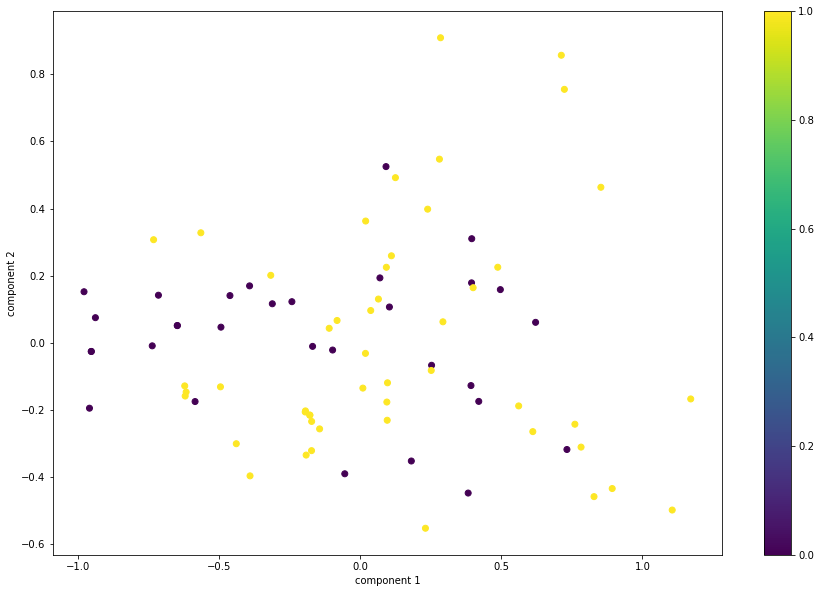

In [98]:
c_a = "Biogen"
c_b = "Shire"

company_viz(c_a,c_b)